In [1]:
# Importing the relevant libraries
import numpy as np
import pandas as pd
import math
import statistics as stat
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau

### Dataset Cleaning

In [2]:
# Ratings Dataset
ratings_data = pd.read_csv(r"ml-latest-small/ratings.csv")

# Dropping 'Timestamp' as it is not required
ratings_data = ratings_data.drop(columns = ["timestamp"])
ratings_data.head() 

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [3]:
# Movies Dataset
movies_data = pd.read_csv(r"ml-latest-small/movies.csv")

# Dropping 'Genres' as it is not required
movies_data = movies_data.drop(columns = ["genres"])
movies_data.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [4]:
# Calculating the length of unique users in the dataset just for the knowledge and check purpose
len(ratings_data["userId"].unique())

610

### User-Based Collaborative Filtering

For producing group recommendation, we will use the user-based collaborative filtering approach. Specifically, for producing group recommendations, we will first compute the movies recommendations for each user in the group, and then we will aggregate the lists of the individual users, so as to produce a single list of movies for the group.

In [5]:
#Picking up a random user (userId= 155) 
uId = 155
inputMovies = ratings_data[ratings_data['userId']== uId]
inputMovies.head()

,userId,movieId,rating
22638,155,1,3.0
22639,155,141,3.0
22640,155,153,3.0
22641,155,260,4.0
22642,155,333,4.0


In [6]:
# Number of movies that selected user has rated/watched
len(inputMovies)

46

In [7]:
# Now we will find out the similar users like the selected user
# Alternately, we can say, finding the useres who rates similar movies as our selected user
similarUsersA = ratings_data[ratings_data['movieId'].isin(inputMovies['movieId'].tolist())]
len(similarUsersA['userId'].unique())

558

In [8]:
# Creating sub dataframes based on userId
similarUsersGroupA = similarUsersA.groupby(['userId'])

In [9]:
# Let's sort those users dataframes
# So that, users with most in common with the selected user will have the priority
similarUsersGroupA = sorted(similarUsersGroupA, key= lambda x:len(x[1]), reverse = True)

In [10]:
# Inspecting the 2nd top user (1st one is the same as our selected user)
similarUsersGroupA[1]

(414,
        userId  movieId  rating
 62294     414        1     4.0
 62352     414      141     4.0
 62358     414      153     2.0
 62410     414      260     5.0
 62439     414      333     3.0
 62484     414      432     2.0
 62552     414      588     4.0
 62555     414      592     4.0
 62576     414      671     4.0
 62725     414     1200     5.0
 62784     414     1302     4.0
 62805     414     1377     4.0
 62842     414     1517     5.0
 62848     414     1562     2.0
 62851     414     1580     4.0
 62930     414     1883     3.0
 62939     414     1917     4.0
 62944     414     1923     5.0
 62957     414     1968     5.0
 62980     414     2028     5.0
 63097     414     2355     4.0
 63160     414     2502     4.0
 63188     414     2628     4.0
 63213     414     2724     1.0
 63276     414     2948     3.0
 63280     414     2959     5.0
 63307     414     3052     3.0
 63327     414     3114     5.0
 63342     414     3175     4.0
 63448     414     3555     3.0
 6

In [11]:
#Length of the movies watched by the userId=414 and its respective ratings
len(similarUsersGroupA[1][1])

35

In [12]:
### Calculating The Similarity (Pearson Correlation) of the Selected (Input) User to the Similar User
# Here, limiting the number to 100 Similar Users while computing the Similarity Score using pearson corrrelation.
similarUsersGroupA = similarUsersGroupA[1:101] # Removing the first user (userId =155), as it is our selected user
len(similarUsersGroupA)

100

In [13]:
# Store the Pearson Correlation in a dictionary, 
# where the key is the user Id and the value is the coefficient
def pearsonCorr(similarUsersGroup):
    pearsonCorrelationDict = {}
    #For every similar user group in our subset
    for name, group in similarUsersGroup:

        #Let's start by sorting the input and current user group so the values aren't mixed up later on
        group = group.sort_values(by='movieId')
        inputMovies1 = inputMovies.sort_values(by='movieId')

        #Get the N (total similar movies watched) for the formula 
        #nRatings = len(group)

        #Get the review scores of the Selected user for the movies that they both have in common
        temp_df = inputMovies1[inputMovies1['movieId'].isin(group['movieId'].tolist())]

        #And then store them in a temporary buffer variable in a list format to facilitate future calculations
        selectedUserTempRatingList = temp_df['rating'].tolist()
        #print(selectedUserTempRatingList)

        #Let's also put the current user group reviews in a list format
        similarUserTempRatingList = group['rating'].tolist()

        #Calculating pearson similarity
        simXX = 0
        meanSelectedUserTempRating = stat.mean(selectedUserTempRatingList)
        for i in selectedUserTempRatingList:
            simXX = simXX + pow((i - meanSelectedUserTempRating),2)

        simYY = 0
        meanSimilarUserTempRaning = stat.mean(similarUserTempRatingList)
        for j in similarUserTempRatingList:
            simYY = simYY + pow((j - meanSimilarUserTempRaning),2)

        simXY = 0
        for i, j in zip(selectedUserTempRatingList, similarUserTempRatingList):
            simXY = simXY+ ((i - meanSelectedUserTempRating ) * (j-meanSimilarUserTempRaning))

        #If the denominator is different than zero, then divide, else, 0 correlation.
        if simXX != 0 and simYY != 0:
            pearsonCorrelationDict[name] = simXY/np.sqrt(simXX*simYY)
        else:
            pearsonCorrelationDict[name] = 0                    
    
    maxSimilarUser = dict(sorted(pearsonCorrelationDict.items(), key=lambda item: item[1], reverse= True))
    return maxSimilarUser

In [14]:
def similarUsersofUserID (pearsonCorrelationDict):  
    #Converting the Pearson Correlation Dictionary into a Data Frame
    similarityScoreofSimilarUsers_data = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
    similarityScoreofSimilarUsers_data.head()
    
    #Similarity score of other similar users to our selected user (155)
    similarityScoreofSimilarUsers_data.columns = ['similarityScore']
    similarityScoreofSimilarUsers_data['userId'] = similarityScoreofSimilarUsers_data.index
    similarityScoreofSimilarUsers_data.index = range(len(similarityScoreofSimilarUsers_data))
    
    #Sorting the DataFrame by the parameter called 'SimilarityScore'
    topSimilarUsers=similarityScoreofSimilarUsers_data.sort_values(by='similarityScore', ascending=False)
    
    # Merging the top similar users similarity score with their ratings of movies
    topSimilarUsersRating = topSimilarUsers.merge(ratings_data, left_on='userId', right_on='userId', how='inner')
    
    # Calculating the mean ratings of all the similar users
    meanRb = topSimilarUsersRating.groupby('userId').mean()[['rating']]
    meanRb.columns = ['avgRating']
    meanRb['userId'] = meanRb.index
    meanRb.index = range(len(meanRb))
    
    # Merging the top similar users average rating score 
    topSimilarUsersRating = topSimilarUsersRating.merge(meanRb, left_on='userId', right_on='userId', how='inner')
    
    #Multiplies the similarity by the user's ratings
    topSimilarUsersRating['weighteratings_datacore'] = topSimilarUsersRating['similarityScore']*(topSimilarUsersRating['rating']-topSimilarUsersRating['avgRating'])
    
    #Applies a sum to the topUsers after grouping it up by userId
    tempTopSimilarUsersRating = topSimilarUsersRating.groupby('movieId').sum()[['weighteratings_datacore']]
    tempTopSimilarUsersRating.columns = ['sum_weighteratings_datacore']
    tempTopSimilarUsersRating['movieId'] = tempTopSimilarUsersRating.index
    
    #Creates an empty dataframe
    recommendation_data = pd.DataFrame()
    
    #Now we take the weighted average
    meanRa = inputMovies['rating'].mean()
    recommendation_data['weighted average recommendation score'] = meanRa+(tempTopSimilarUsersRating['sum_weighteratings_datacore']/topSimilarUsers['similarityScore'].sum())
    recommendation_data['movieId'] = recommendation_data.index
    recommendation_data = recommendation_data.sort_values(by='weighted average recommendation score', ascending=False)
    recommendation_data.index = [x for x in range(1,len(recommendation_data)+1)]
    
    return recommendation_data

In [15]:
# Calling the function Pearson Correlation for calculating the similarity index
pearsonCorrelationDictA = pearsonCorr(similarUsersGroupA)

# Calling the function for generating recommendations for every user
recMovieA = similarUsersofUserID(pearsonCorrelationDictA)
recMovieA.head()

,weighted average recommendation score,movieId
1,4.936516,2028
2,4.925712,2628
3,4.742338,1210
4,4.735162,260
5,4.686289,3578


In [16]:
#lets see users who are similar to user A by looking at correlation dictionary
pearsonCorrelationDictA

{93: 0.7654779007031433,
 522: 0.6254850496163783,
 580: 0.6242043281306189,
 82: 0.6155784217875951,
 608: 0.4464873000525615,
 560: 0.40311288741492746,
 115: 0.392232270276368,
 596: 0.33167432240867145,
 122: 0.32935017447568277,
 140: 0.3125050443499249,
 266: 0.3077287274483318,
 428: 0.3074593469062211,
 304: 0.29922359520533415,
 368: 0.2977375870413793,
 232: 0.27363506726182907,
 166: 0.2554811008995235,
 387: 0.2550121784479975,
 294: 0.2123284749005513,
 19: 0.204019442118549,
 167: 0.1968460971107301,
 573: 0.19595922445781594,
 68: 0.19353991202063656,
 477: 0.18613560821740874,
 217: 0.18553546269482762,
 1: 0.1836110532684469,
 474: 0.18122313057747416,
 57: 0.18093806238429008,
 570: 0.17523075771408575,
 28: 0.17351520648554244,
 600: 0.17194120423502943,
 483: 0.16610262808732373,
 91: 0.1640089328533902,
 288: 0.15233821244244802,
 534: 0.14718657970402252,
 42: 0.13880363049242067,
 313: 0.13227116931706753,
 603: 0.13130643285972246,
 425: 0.12632107408842633,
 23

In [17]:
#Lets take 93 and 522 so lets produce recommendation for them
#The same approach is followed for the following two users as done for the userA.
#The approach is basically finding the most similar users for userB and userC 
#Then followed by calculating the pearson correlation similarity index and moreover generating recommendations for every user.
# Following are the users and their respective ids for understanding the meaning for every variable name.
# For UserB: - userId= 93
# For UserC: - userId = 522

In [18]:
# For UserB: - userId= 93
uId = 93
inputMovies = ratings_data[ratings_data['userId']== uId]
similarUsersB = ratings_data[ratings_data['movieId'].isin(inputMovies['movieId'].tolist())]
similarUsersB= ratings_data[ratings_data['movieId'].isin(inputMovies['movieId'].tolist())]
similarUsersGroupB= similarUsersB.groupby(['userId'])
similarUsersGroupB= sorted(similarUsersGroupB, key= lambda x:len(x[1]), reverse = True)
similarUsersGroupB= similarUsersGroupB[1:101] # Removing the first user (userId =93 as it is our selected user
pearsonCorrelationDictB = pearsonCorr(similarUsersGroupB)
recMovieB = similarUsersofUserID(pearsonCorrelationDictB)

In [19]:
recMovieB.head()

,weighted average recommendation score,movieId
1,5.305598,296
2,5.284396,260
3,5.231781,1196
4,5.183856,1198
5,5.172042,356


In [20]:
# For UserC: - userId = 522
uId = 522
inputMovies = ratings_data[ratings_data['userId']== uId]
similarUsersC= ratings_data[ratings_data['movieId'].isin(inputMovies['movieId'].tolist())]
similarUsersC=ratings_data[ratings_data['movieId'].isin(inputMovies['movieId'].tolist())]
similarUsersGroupC=similarUsersC.groupby(['userId'])
similarUsersGroupC= sorted(similarUsersGroupC, key= lambda x:len(x[1]), reverse = True)
similarUsersGroupC= similarUsersGroupC[1:101] # Removing the first user (userId =522 as it is our selected user
pearsonCorrelationDictC = pearsonCorr(similarUsersGroupC)
recMovieC = similarUsersofUserID(pearsonCorrelationDictC)

In [21]:
recMovieC.head()

,weighted average recommendation score,movieId
1,4.818355,296
2,4.668130,1196
3,4.653819,2959
4,4.630776,260
5,4.622607,2571


### Aggregation

You will implement two well established aggregation methods for producing the group recommendations.<br>
<br>
The first aggregation approach is the average method <br>
The main idea behind this approach is that all members are considered equals. So, the rating of an item for a group of users will be given be averaging the scores of an item across all group members. <br>
<br>
The second aggregation method is the least misery method <br>
Where one member can act as a veto for the rest of the group. In this case, the rating of an item for a group of users is computed as the minimum score assigned to that item in all group members recommendations. 

### Average Aggregation Method

In [22]:
## Mergeing the recommendation DataFrames for userA and userB 
u1_2_df = pd.merge(recMovieA, recMovieB, how='inner', on=['movieId'])
u1_2_df.head()

,weighted average recommendation score_x,movieId,weighted average recommendation score_y
0,4.936516,2028,5.071311
1,4.925712,2628,4.268957
2,4.742338,1210,5.057910
3,4.735162,260,5.284396
4,4.686289,3578,4.658745


In [23]:
## Mergeing the recommendation DataFrames for userA,userB with useC 
uCombined_df = pd.merge(u1_2_df, recMovieC, how='inner', on=['movieId'])
uCombined_df.head()

,weighted average recommendation score_x,movieId,weighted average recommendation score_y,weighted average recommendation score
0,4.936516,2028,5.071311,4.334429
1,4.925712,2628,4.268957,3.405232
2,4.742338,1210,5.057910,4.546547
3,4.735162,260,5.284396,4.630776
4,4.686289,3578,4.658745,4.080071


In [24]:
## Calculating the average aggregration dictionary for group of three users: - UserA, UserB, UserC
avgMovieRatings = {}
for i in range(0, len(uCombined_df)-1):
    sum = uCombined_df.iloc[i]['weighted average recommendation score_x'] + uCombined_df.iloc[i]['weighted average recommendation score_y'] + uCombined_df.iloc[i]['weighted average recommendation score']
    avgRating = int(sum/3)
    tempDict = {uCombined_df.iloc[i]['movieId']: avgRating}
    avgMovieRatings.update(tempDict)
    
avgMovieRatings = dict(sorted(avgMovieRatings.items(), key=lambda item: item[1], reverse= True))
avgMovieRatings

{2028.0: 4,
 2628.0: 4,
 1210.0: 4,
 260.0: 4,
 3578.0: 4,
 6934.0: 4,
 2571.0: 4,
 1196.0: 4,
 5378.0: 4,
 296.0: 4,
 3994.0: 4,
 1923.0: 4,
 6365.0: 4,
 1198.0: 4,
 1291.0: 4,
 1200.0: 4,
 1580.0: 4,
 2959.0: 4,
 1732.0: 4,
 589.0: 4,
 1356.0: 4,
 1653.0: 4,
 47.0: 4,
 32.0: 4,
 7153.0: 4,
 858.0: 4,
 1527.0: 4,
 1214.0: 4,
 33493.0: 4,
 1197.0: 4,
 1374.0: 4,
 6537.0: 4,
 4310.0: 4,
 4027.0: 4,
 3793.0: 4,
 4223.0: 4,
 527.0: 4,
 1222.0: 4,
 293.0: 4,
 32587.0: 4,
 5418.0: 4,
 4993.0: 4,
 1206.0: 4,
 3753.0: 4,
 1784.0: 4,
 33794.0: 4,
 34405.0: 4,
 1610.0: 4,
 2115.0: 4,
 1089.0: 4,
 4816.0: 4,
 5266.0: 4,
 5903.0: 4,
 48516.0: 4,
 6188.0: 4,
 110.0: 4,
 1704.0: 4,
 31696.0: 4,
 4306.0: 4,
 1266.0: 4,
 1682.0: 4,
 2762.0: 4,
 3703.0: 4,
 53996.0: 4,
 1199.0: 4,
 44191.0: 4,
 6947.0: 4,
 1372.0: 4,
 3300.0: 4,
 1136.0: 4,
 3275.0: 4,
 1953.0: 4,
 5349.0: 4,
 778.0: 4,
 50.0: 4,
 163.0: 4,
 6539.0: 4,
 1208.0: 4,
 1566.0: 4,
 1500.0: 4,
 8371.0: 4,
 3160.0: 4,
 2502.0: 4,
 5254.0: 4,

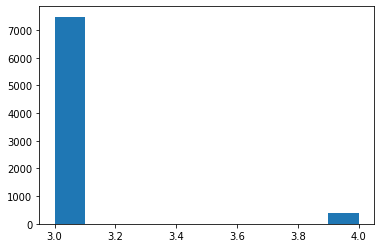

In [25]:
plt.hist(avgMovieRatings.values())
plt.show()

Produce a group of 3 users, and for this group, show the top-20 recommendations, i.e., the 20 movies with the highest prediction scores that the average method suggest. 

In [26]:
# Formating the dataFrame by assigning the column names
avgMovieRatings_df = pd.DataFrame(avgMovieRatings.items())
avgMovieRatings_df = pd.DataFrame(avgMovieRatings.items(), columns = ['movieId', 'group_ratings'])
avgMovieRatings_df.head(20)

,movieId,group_ratings
0,2028.0,4
1,2628.0,4
2,1210.0,4
3,260.0,4
4,3578.0,4
5,6934.0,4
6,2571.0,4
7,1196.0,4
8,5378.0,4
9,296.0,4


### Least Misery Aggregation Method

In [27]:
## Calculating the least misery dictionary for group of three users: - UserA, UserB, UserC
leastMiseryRatings = {}
for i in range(0, len(uCombined_df)-1):
    min_val = int(min(uCombined_df.iloc[i]['weighted average recommendation score_x'], uCombined_df.iloc[i]['weighted average recommendation score_y'], uCombined_df.iloc[i]['weighted average recommendation score']))
    tempDict1 = {uCombined_df.iloc[i]['movieId']: min_val}
    leastMiseryRatings.update(tempDict1)
    
leastMiseryRatings = dict(sorted(leastMiseryRatings.items(), key=lambda item: item[1], reverse= True))
leastMiseryRatings

{2028.0: 4,
 1210.0: 4,
 260.0: 4,
 3578.0: 4,
 2571.0: 4,
 1196.0: 4,
 296.0: 4,
 1198.0: 4,
 1291.0: 4,
 1200.0: 4,
 2959.0: 4,
 1732.0: 4,
 589.0: 4,
 1653.0: 4,
 47.0: 4,
 32.0: 4,
 7153.0: 4,
 858.0: 4,
 1527.0: 4,
 1214.0: 4,
 1197.0: 4,
 4027.0: 4,
 3793.0: 4,
 527.0: 4,
 1222.0: 4,
 293.0: 4,
 32587.0: 4,
 4993.0: 4,
 1206.0: 4,
 1784.0: 4,
 33794.0: 4,
 1610.0: 4,
 2115.0: 4,
 1089.0: 4,
 2628.0: 3,
 6934.0: 3,
 5378.0: 3,
 3994.0: 3,
 1923.0: 3,
 6365.0: 3,
 1580.0: 3,
 1356.0: 3,
 33493.0: 3,
 1374.0: 3,
 6537.0: 3,
 4310.0: 3,
 4223.0: 3,
 5418.0: 3,
 3753.0: 3,
 5502.0: 3,
 34405.0: 3,
 45722.0: 3,
 3717.0: 3,
 6373.0: 3,
 6564.0: 3,
 4816.0: 3,
 5266.0: 3,
 5903.0: 3,
 48516.0: 3,
 6188.0: 3,
 110.0: 3,
 1704.0: 3,
 31696.0: 3,
 4306.0: 3,
 1266.0: 3,
 1682.0: 3,
 2762.0: 3,
 3703.0: 3,
 53996.0: 3,
 1199.0: 3,
 44191.0: 3,
 6754.0: 3,
 6541.0: 3,
 6947.0: 3,
 3863.0: 3,
 34048.0: 3,
 1372.0: 3,
 3300.0: 3,
 1136.0: 3,
 3275.0: 3,
 1953.0: 3,
 5349.0: 3,
 778.0: 3,
 50.0:

In [28]:
# Formating the dataFrame by assigning the column names
leastMiseryRatings_df = pd.DataFrame(leastMiseryRatings.items())
leastMiseryRatings_df = pd.DataFrame(leastMiseryRatings.items(), columns = ['movieId', 'group_ratings'])
leastMiseryRatings_df

,movieId,group_ratings
0,2028.0,4
1,1210.0,4
2,260.0,4
3,3578.0,4
4,2571.0,4
...,...,...
7855,919.0,2
7856,153.0,2
7857,158.0,2
7858,2384.0,2


In [29]:
# Top 20 Recommendations for the Group of users (UserA, UserB, UserC) by the score of Average Aggregration
movies_data.loc[movies_data['movieId'].isin(avgMovieRatings_df.head(20)['movieId'].tolist())]

,movieId,title
224,260,Star Wars: Episode IV - A New Hope (1977)
257,296,Pulp Fiction (1994)
507,589,Terminator 2: Judgment Day (1991)
898,1196,Star Wars: Episode V - The Empire Strikes Back...
900,1198,Raiders of the Lost Ark (Indiana Jones and the...
902,1200,Aliens (1986)
911,1210,Star Wars: Episode VI - Return of the Jedi (1983)
990,1291,Indiana Jones and the Last Crusade (1989)
1183,1580,Men in Black (a.k.a. MIB) (1997)
1298,1732,"Big Lebowski, The (1998)"


Produce a group of 3 users, and for this group, show the top-20 recommendations, i.e., the 20 movies with the highest prediction scores that the least misery method suggest. 

In [30]:
# Top 20 Recommendations for the Group of users (UserA, UserB, UserC) by the score of Least Misery
movies_data.loc[movies_data['movieId'].isin(leastMiseryRatings_df.head(20)['movieId'].tolist())]

,movieId,title
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
43,47,Seven (a.k.a. Se7en) (1995)
224,260,Star Wars: Episode IV - A New Hope (1977)
257,296,Pulp Fiction (1994)
507,589,Terminator 2: Judgment Day (1991)
659,858,"Godfather, The (1972)"
898,1196,Star Wars: Episode V - The Empire Strikes Back...
900,1198,Raiders of the Lost Ark (Indiana Jones and the...
902,1200,Aliens (1986)
911,1210,Star Wars: Episode VI - Return of the Jedi (1983)


### Recommendation with disagreements

The methods we will consider any disagreements between the users in the group. <br>
We will define a way for counting the disagreements between the users in a group, and propose a method that takes disagreements into account when computing suggestions for the group. 

In [31]:
# Importing the Datasets ratings and movies
ratings = pd.read_csv(r"ml-latest-small/ratings.csv")
movies = pd.read_csv(r"ml-latest-small/movies.csv")

# Dropping 'Timestamp' as it is not required
ratings = ratings.drop(columns = ["timestamp"])

# Dropping 'Genres' as it is not required
movies = movies.drop(columns = ["genres"])


# Calculating the length of unique users in the dataset just for the knowledge and check purpose
print(f'Number of unique users {len(ratings["userId"].unique())}')

Number of unique users 610


In [32]:
# Picking up a random user (userId= 87) 
userA = 87 

In [33]:
# Fuction for creating dataset of a single user with all the movies he has rated
def create_userX_matrix(userId):
    userX_matrix = ratings.query('userId == @userId',inplace = False)
    return userX_matrix

# Fuction for finding other similar user who has watched some/all similar movies with the selected user(userId)
def user_subset_common_movie(userId):
    userX_matrix = create_userX_matrix(userId)
    users = ratings[ratings['movieId'].isin(userX_matrix['movieId'].tolist())]
    # Creating sub dataframes based on userId
    userSubsetGroup = users.groupby(['userId'])
    # Sorting the sub dataframe of all simmilar users so that top common with the selected user will have the priority
    userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)
    userSubsetGroup = userSubsetGroup[1:81]
    return userSubsetGroup, userX_matrix

In [34]:
# Now we will find out the similar users like the selected user (userId= 87) 
# Alternately, we can say, finding the useres who rates similar movies as our selected user
userSubsetGroupA, userAMatrix = user_subset_common_movie(userA)

In [35]:
# Inspecting the 2nd top user (1st one is the same as our selected user)
userSubsetGroupA[1]

(474,
        userId  movieId  rating
 73164     474      262     4.0
 73260     474      671     3.5
 73370     474     1077     3.5
 73392     474     1136     4.5
 73494     474     1345     3.5
 73548     474     1584     3.5
 73656     474     2009     3.0
 73713     474     2139     4.0
 73764     474     2300     4.5
 74090     474     3504     4.0
 74165     474     3910     4.0
 74309     474     4571     4.5
 74377     474     4973     5.0
 74474     474     5618     4.5
 74522     474     5971     4.0)

In [36]:
# Total number of similar user who has rated most common movies as selected user (userId= 87)  
len(userSubsetGroupA)

80

In [37]:
# Store the Pearson Correlation in a dictionary, 
# where the key is the user Id and the value is the coefficient
def pearsonCorr(inputMovies, similarUsersGroup):
    pearsonCorrelationDict = {}
    # For every similar user group in our subset
    for name, group in similarUsersGroup:

        # Let's start by sorting the input and current user group so the values aren't mixed up later on
        group = group.sort_values(by='movieId')
        inputMovies1 = inputMovies.sort_values(by='movieId')

        # Get the N (total similar movies watched) for the formula 
        # nRatings = len(group)

        # Get the review scores of the Selected user for the movies that they both have in common
        temp_df = inputMovies1[inputMovies1['movieId'].isin(group['movieId'].tolist())]

        # And then store them in a temporary buffer variable in a list format to facilitate future calculations
        selectedUserTempRatingList = temp_df['rating'].tolist()
        # print(selectedUserTempRatingList)

        # Let's also put the current user group reviews in a list format
        similarUserTempRatingList = group['rating'].tolist()

        # Calculating pearson similarity
        simXX = 0
        meanSelectedUserTempRating = stat.mean(selectedUserTempRatingList)
        for i in selectedUserTempRatingList:
            simXX = simXX + pow((i - meanSelectedUserTempRating),2)

        simYY = 0
        meanSimilarUserTempRaning = stat.mean(similarUserTempRatingList)
        for j in similarUserTempRatingList:
            simYY = simYY + pow((j - meanSimilarUserTempRaning),2)

        simXY = 0
        for i, j in zip(selectedUserTempRatingList, similarUserTempRatingList):
            simXY = simXY+ ((i - meanSelectedUserTempRating ) * (j-meanSimilarUserTempRaning))

        # If the denominator is different than zero, then divide, else, 0 correlation.
        if simXX != 0 and simYY != 0:
            pearsonCorrelationDict[name] = simXY/np.sqrt(simXX*simYY)
        else:
            pearsonCorrelationDict[name] = 0                    
    
    maxSimilarUser = dict(sorted(pearsonCorrelationDict.items(), key=lambda item: item[1], reverse= True))
    return maxSimilarUser

In [38]:
# Similarity score of other similar users to our selected user (155)
def similarUsersofUserID (inputMovies, pearsonCorrelationDict):
    similarityScoreofSimilarUsers_data = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
    similarityScoreofSimilarUsers_data.head()
    similarityScoreofSimilarUsers_data.columns = ['similarityScore']
    similarityScoreofSimilarUsers_data['userId'] = similarityScoreofSimilarUsers_data.index
    similarityScoreofSimilarUsers_data.index = range(len(similarityScoreofSimilarUsers_data))
    #similarityScoreofSimilarUsers_data.head()
    topSimilarUsers=similarityScoreofSimilarUsers_data.sort_values(by='similarityScore', ascending=False)
    topSimilarUsers.head(10)
    topSimilarUsersRating = topSimilarUsers.merge(ratings, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating.head()
    meanRb = topSimilarUsersRating.groupby('userId').mean()[['rating']]
    meanRb.columns = ['avgRating']
    meanRb['userId'] = meanRb.index
    meanRb.index = range(len(meanRb))
    topSimilarUsersRating = topSimilarUsersRating.merge(meanRb, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating['weighteratings_datacore'] = topSimilarUsersRating['similarityScore']*(topSimilarUsersRating['rating']-topSimilarUsersRating['avgRating'])
    tempTopSimilarUsersRating = topSimilarUsersRating.groupby('movieId').sum()[['weighteratings_datacore']]
    tempTopSimilarUsersRating.columns = ['sum_weighteratings_datacore']
    tempTopSimilarUsersRating['movieId'] = tempTopSimilarUsersRating.index
    
    #Creates an empty dataframe
    recommendation_data = pd.DataFrame()
    #Now we take the weighted average
    meanRa = inputMovies['rating'].mean()
    recommendation_data['weighted average recommendation score'] = meanRa+(tempTopSimilarUsersRating['sum_weighteratings_datacore']/topSimilarUsers['similarityScore'].sum())
    recommendation_data['movieId'] = recommendation_data.index
    recommendation_data = recommendation_data.sort_values(by='weighted average recommendation score', ascending=False)
    recommendation_data.index = [x for x in range(1,len(recommendation_data)+1)]
    return recommendation_data

In [39]:
# Calling the function Pearson Correlation for calculating the similarity index in terms of 1st user in the group (userId= 87)  
pearsonCorrelationDictA = pearsonCorr(userAMatrix, userSubsetGroupA)

# Calling the function for generating recommendations in terms of 1st user in the group userA (userId= 87) 
recMovieA = similarUsersofUserID(userAMatrix, pearsonCorrelationDictA)
recMovieA

,weighted average recommendation score,movieId
1,4.793109,1136
2,4.757803,296
3,4.665111,2959
4,4.615243,318
5,4.589333,1196
...,...,...
8407,3.564032,153
8408,3.563826,3593
8409,3.543843,355
8410,3.536890,158


In [40]:
# lets see users who are similar to 1st user in the group userA (userId= 87) by looking at correlation dictionary
pearsonCorrelationDictA

{398: 1.0,
 560: 1.0,
 265: 0.9771398364036775,
 41: 0.9707253433941511,
 334: 0.9704949588309458,
 428: 0.9683296637314885,
 580: 0.967805338634417,
 167: 0.9486832980505138,
 483: 0.9432422182837988,
 239: 0.9428090415820635,
 489: 0.9333456062030596,
 520: 0.9229379806514804,
 63: 0.917662935482247,
 57: 0.9072221051385091,
 525: 0.9053914609204582,
 20: 0.9045340337332909,
 95: 0.9045340337332909,
 84: 0.8944271909999159,
 104: 0.8783100656536799,
 480: 0.8760940310493247,
 91: 0.8703882797784892,
 122: 0.8660254037844387,
 477: 0.8593378488473195,
 448: 0.8563848794370408,
 177: 0.8353351483845165,
 226: 0.8235052638205963,
 356: 0.8164965809277261,
 288: 0.8125,
 298: 0.8071929013058705,
 601: 0.7745966692414834,
 414: 0.7512457176166563,
 105: 0.7434596427763639,
 380: 0.7135060680126758,
 66: 0.6897007348075542,
 221: 0.6507913734559685,
 132: 0.6454972243679028,
 135: 0.6274950199005567,
 606: 0.6004805767690768,
 246: 0.5964098406184938,
 339: 0.5773502691896258,
 599: 0.5720

In [41]:
# As userId = 398 and userId = 560 has the highest similarity score with our selected userA
# So, lets take 398 and 560 so lets produce recommendation for them, based on pearson correlation value
# The same approach is followed for the following two users as done for the userA.
# The approach is basically finding the most similar users for userB and userC 

In [42]:
# 2nd user of the group
userB = 398

# finding the useres who rates similar movies as our selected userB
userSubsetGroupB, userBMatrix = user_subset_common_movie(userB)

#Calling the function Pearson Correlation for calculating the similarity index in terms of 1st user in the group userB
pearsonCorrelationDictB = pearsonCorr(userBMatrix, userSubsetGroupB)

#Calling the function for generating recommendations in terms of 1st user in the group userB 
recMovieB = similarUsersofUserID(userBMatrix, pearsonCorrelationDictB)
recMovieB

,weighted average recommendation score,movieId
1,5.206885,1136
2,5.093475,296
3,4.999301,318
4,4.937514,1196
5,4.932871,1197
...,...,...
8422,3.802239,153
8423,3.787336,1544
8424,3.785265,6934
8425,3.783206,1917


In [43]:
#2nd user of the group
userC = 560

# finding the useres who rates similar movies as our selected userC
userSubsetGroupC, userCMatrix = user_subset_common_movie(userC)

#Calling the function Pearson Correlation for calculating the similarity index in terms of 1st user in the group userC
pearsonCorrelationDictC = pearsonCorr(userCMatrix, userSubsetGroupC)

#Calling the function for generating recommendations in terms of 1st user in the group userC
recMovieC = similarUsersofUserID(userCMatrix, pearsonCorrelationDictC)
recMovieC

,weighted average recommendation score,movieId
1,4.639140,296
2,4.555321,2959
3,4.387194,1196
4,4.354249,858
5,4.338858,260
...,...,...
8304,3.150671,153
8305,3.136917,788
8306,3.113496,2701
8307,3.011886,3623


In [44]:
#List of recommendations movies for 1st user in the group userA
aUserList = recMovieA['movieId'].tolist()

#List of recommendations movies for 1st user in the group userB
bUserList = recMovieB['movieId'].tolist()

#List of recommendations movies for 1st user in the group userC
cUserList = recMovieC['movieId'].tolist()

In [45]:
#The common recommended movies of all users (userA, userB, userC) in group
commonRecMovAverage = set(aUserList) & set(bUserList) & set(cUserList)

#Total number of common recommended movies of all users (userA, userB, userC) in group
len(commonRecMovAverage)

7864

In [46]:
#Finding only the common movies between users with the recommendation score with UserA
recMovieA = recMovieA[recMovieA['movieId'].isin(commonRecMovAverage)]

#Finding only the common movies between users with the recommendation score with UserB
recMovieB = recMovieB[recMovieB['movieId'].isin(commonRecMovAverage)]

#Finding only the common movies between users with the recommendation score with UserC
recMovieC = recMovieC[recMovieC['movieId'].isin(commonRecMovAverage)]

In [47]:
#Calculate the average aggregation with the value of individual recommendation score of each common movie between the users (userA, userB, userC) in group
frames = [recMovieA, recMovieB, recMovieC]
result = pd.concat(frames)

GroupRecommendationAverage = result.groupby(['movieId'], as_index= False).mean().sort_values(by='weighted average recommendation score', ascending=False)
GroupRecommendationAverage.index = [x for x in range(1, len(GroupRecommendationAverage)+1)]
GroupRecommendationAverage

,movieId,weighted average recommendation score
1,296,4.830139
2,1136,4.747574
3,2959,4.705039
4,1196,4.638014
5,318,4.632444
...,...,...
7860,3977,3.535711
7861,2628,3.534928
7862,3623,3.507888
7863,153,3.505647


In [48]:
#Concating the movieId with the movie title from the collective movie list after average aggregation  
movies.loc[movies['movieId'].isin(GroupRecommendationAverage.head(20)['movieId'])]['title']

46                             Usual Suspects, The (1995)
224             Star Wars: Episode IV - A New Hope (1977)
257                                   Pulp Fiction (1994)
277                      Shawshank Redemption, The (1994)
314                                   Forrest Gump (1994)
474                                   Blade Runner (1982)
510                      Silence of the Lambs, The (1991)
520                                          Fargo (1996)
659                                 Godfather, The (1972)
828                                 Reservoir Dogs (1992)
863                Monty Python and the Holy Grail (1975)
898     Star Wars: Episode V - The Empire Strikes Back...
899                            Princess Bride, The (1987)
900     Raiders of the Lost Ark (Indiana Jones and the...
911     Star Wars: Episode VI - Return of the Jedi (1983)
1939                                   Matrix, The (1999)
2226                                    Fight Club (1999)
3141          

In [49]:
#Calculate the Least Mesury aggregation with the value of individual recommendation score of each common movie between the users (userA, userB, userC) in group
GroupRecommendationLM = result.groupby(['movieId'], as_index = False).min().sort_values(by='weighted average recommendation score', ascending=False)
GroupRecommendationLM.index = [x for x in range(1, len(GroupRecommendationLM)+1)]
GroupRecommendationLM

,movieId,weighted average recommendation score
1,296,4.639140
2,2959,4.555321
3,1196,4.387194
4,858,4.354249
5,260,4.338858
...,...,...
7860,153,3.150671
7861,788,3.136917
7862,2701,3.113496
7863,3623,3.011886


In [50]:
#Concating the movieId with the movie title from the collective movie list after Least Measury aggregation 
movies.loc[movies['movieId'].isin(GroupRecommendationLM.head(20)['movieId'])]['title']

46                             Usual Suspects, The (1995)
224             Star Wars: Episode IV - A New Hope (1977)
254     Léon: The Professional (a.k.a. The Professiona...
257                                   Pulp Fiction (1994)
277                      Shawshank Redemption, The (1994)
510                      Silence of the Lambs, The (1991)
659                                 Godfather, The (1972)
828                                 Reservoir Dogs (1992)
863                Monty Python and the Holy Grail (1975)
898     Star Wars: Episode V - The Empire Strikes Back...
911     Star Wars: Episode VI - Return of the Jedi (1983)
1298                             Big Lebowski, The (1998)
1939                                   Matrix, The (1999)
2226                                    Fight Club (1999)
3141                                       Memento (2000)
3638    Lord of the Rings: The Fellowship of the Ring,...
4137        Lord of the Rings: The Two Towers, The (2002)
4615          

In [51]:
#let's create Kendall-Tau distance calculation to evaluate the recommendation of our grouping (against Average Aggregation method)

#List of recommendations movies for 1st user in the group userA
aUserList = recMovieA['movieId'].tolist()

#List of recommendations movies for 1st user in the group userB
bUserList = recMovieB['movieId'].tolist()

#List of recommendations movies for 1st user in the group userC
cUserList = recMovieC['movieId'].tolist()

#listing the common movie Id from the Average Aggregation method
averageList = GroupRecommendationAverage['movieId'].tolist()
len(averageList)

7864

In [52]:
#Kandall Tau Correlation between movie rank between userA with the commom group movie rank (aginst Average Aggregation method) 
tauAAVG, p_valueA = kendalltau(aUserList, averageList) 
#Kandall Tau Correlation between movie rank between userB with the commom group movie rank (aginst Average Aggregation method)
tauBAVG, p_valueB = kendalltau(bUserList, averageList) 
#Kandall Tau Correlation between movie rank between userC with the commom group movie rank (aginst Average Aggregation method)
tauCAVG, p_valueC = kendalltau(cUserList, averageList) 

print(f'KT Correlation for user A against Average aggregation method: {tauAAVG}')
print(f'KT Correlation for user B against Average aggregation method: {tauBAVG}')
print(f'KT Correlation for user C against Average aggregation method: {tauCAVG}')

KT Correlation for user A against Average aggregation method: 0.06958708834880752
KT Correlation for user B against Average aggregation method: 0.07953581740407221
KT Correlation for user C against Average aggregation method: 0.05840946866150996


In [53]:
#let's create Kendall-Tau distance calculation to evaluate the recommendation of our grouping (against Least Misery Aggregation method)

#listing the common movie Id from the Least Misery Aggregation method
lmList = GroupRecommendationLM['movieId'].tolist()

#Kandall Tau Correlation between movie rank between userA with the commom group movie rank (aginst Least Misery Aggregation method)
tauALM, p_valueALM = kendalltau(aUserList, lmList) 
#Kandall Tau Correlation between movie rank between userB with the commom group movie rank (aginst Least Misery Aggregation method)
tauBLM, p_valueBLM = kendalltau(bUserList, lmList) 
#Kandall Tau Correlation between movie rank between userC with the commom group movie rank (aginst Least Misery Aggregation method)
tauCLM, p_valueCLM = kendalltau(cUserList, lmList) 

print(f'KT Correlation for user A against LM aggregation method: {tauALM}')
print(f'KT Correlation for user B against LM aggregation method: {tauBLM}')
print(f'KT Correlation for user C against LM aggregation method: {tauCLM}')

KT Correlation for user A against LM aggregation method: 0.04056147694062447
KT Correlation for user B against LM aggregation method: 0.05402396508157435
KT Correlation for user C against LM aggregation method: 0.7287435300011166


In [54]:
#Let's find users that have less disagreement, instead of using pearson correlation, let's count userA against other users
#and find the ones that has the highest Kendall tau correlation
#let's choose users who at least have 30 common rated movies
similarUserA2 = [name for name,group in userSubsetGroupA] 
len(similarUserA2)

80

In [55]:
#Function for finding recommendation with a single user with other user
def produce_recommendation(userId):
    userSubsetGroup, userMatrix = user_subset_common_movie(userId)
    pearsonCorrelationDict = pearsonCorr(userMatrix, userSubsetGroup)
    recMovieX = similarUsersofUserID(userMatrix, pearsonCorrelationDict)
    return recMovieX
    
#Function for kendall_tau correlatuib between users
def kendall_tau_between_users(userId, otherUsers, recMovieA):
    recMovieX = produce_recommendation(userId)
    recMovieListX = recMovieX['movieId'].tolist() #list Of Recommended Movie For UserId
    aUserList = recMovieA['movieId'].tolist()
    commonRecMovAverage = set(aUserList) & set(recMovieListX)
    
    recMovieA = recMovieA[recMovieA['movieId'].isin(commonRecMovAverage)]
    recMovieX = recMovieX[recMovieX['movieId'].isin(commonRecMovAverage)]
    
    recMovieListA = recMovieA['movieId'].tolist()
    recMovieListX = recMovieX['movieId'].tolist()
    
    tauUser, p_valueUser = kendalltau(recMovieListA, recMovieListX) 
    return tauUser
    

In [56]:
#Create dictionary for storing userId with their kendall tau correlation value
KTDict = {}
for user in similarUserA2:
    x = kendall_tau_between_users(user, userSubsetGroupA, recMovieA)
    KTDict[user] = x 
    KTDict = dict(sorted(KTDict.items(), key=lambda item: item[1], reverse= True))

In [57]:
#Showing the itemms of all kendall tau correlation value
KTDict 

#let's take 590 as new userB and 387 new userC because it has the highest kendall tau correlatuib

{590: 0.09419891039422312,
 387: 0.09029350241325511,
 398: 0.08792923680697251,
 346: 0.0833860638058566,
 117: 0.08301875001775302,
 20: 0.08037131631101457,
 135: 0.08024744224824626,
 606: 0.07853868814833186,
 221: 0.07780675464509035,
 474: 0.07772911459035163,
 288: 0.07584611453100641,
 580: 0.07558113903881397,
 275: 0.07412058539425456,
 469: 0.0739153765368795,
 45: 0.07281326192195238,
 307: 0.07280599570857008,
 287: 0.07205456975374804,
 596: 0.07201737599188286,
 599: 0.07151449975229247,
 489: 0.07018003222204582,
 84: 0.06948132302773534,
 64: 0.06937203578562479,
 66: 0.0682712079711008,
 601: 0.06767975782768448,
 239: 0.06581645824883356,
 483: 0.06528054539271844,
 334: 0.06511214907996161,
 156: 0.0650699453531151,
 122: 0.06392243687388136,
 428: 0.06376013051546656,
 177: 0.06302318624047668,
 160: 0.0627938943641118,
 19: 0.06185787138432251,
 57: 0.06159754142082116,
 199: 0.060671924887835404,
 95: 0.060249103893731344,
 414: 0.05980131819955151,
 182: 0.0596

In [58]:
#Finding top recommended movies of new userB 
newRecMovieB = produce_recommendation(590)

#Finding top recommended movies of new userC 
newRecMovieC = produce_recommendation(387)

In [59]:
#List of recommendations movies for 1st user in the group new userA
newAUserList = recMovieA['movieId'].tolist()

#List of recommendations movies for 1st user in the group new userB
newBUserList = newRecMovieB['movieId'].tolist()

#List of recommendations movies for 1st user in the group new userC
newCUserList = newRecMovieC['movieId'].tolist()

#List of recommendations movies for all users in the group users
newCommonRecMov = set(newAUserList) & set(newBUserList) & set(newCUserList)

newRecMovieA = recMovieA[recMovieA['movieId'].isin(newCommonRecMov)]
newRecMovieB = newRecMovieB[newRecMovieB['movieId'].isin(newCommonRecMov)]
newRecMovieC = newRecMovieC[newRecMovieC['movieId'].isin(newCommonRecMov)]

In [60]:
#Calculate the new average aggregation with the value of individual recommendation score of each common movie between the new users (new userA, new userB, new userC) in group
newFrames = [newRecMovieA, newRecMovieB , newRecMovieC]
newResult = pd.concat(newFrames)
newGroupRecommendationAverage =  newResult.groupby(['movieId'], as_index= False).mean().sort_values(by='weighted average recommendation score', ascending=False)
newGroupRecommendationAverage.index = [x for x in range(1, len(newGroupRecommendationAverage)+1)]
newGroupRecommendationAverage

,movieId,weighted average recommendation score
1,296,4.461995
2,2959,4.323017
3,1196,4.321600
4,858,4.272319
5,1136,4.257604
...,...,...
7689,788,3.121975
7690,1544,3.118282
7691,153,3.098540
7692,1562,3.073341


In [61]:
#Concating the movie data with movie title
#movies.loc[movies['movieId'].isin(newGroupRecommendationAverage.head(20)['movieId'])]['title']
newGroupRecommendationAverage['movieName'] = newGroupRecommendationAverage['movieId'].map(movies['title'])
newGroupRecommendationAverage.head(20)

,movieId,weighted average recommendation score,movieName
1,296,4.461995,Virtuosity (1995)
2,2959,4.323017,Billy Elliot (2000)
3,1196,4.321600,Picture Perfect (1997)
4,858,4.272319,Escape from New York (1981)
5,1136,4.257604,Selena (1997)
6,260,4.251074,Quiz Show (1994)
7,2571,4.243710,Teenage Mutant Ninja Turtles II: The Secret of...
8,318,4.212579,I Love Trouble (1994)
9,2858,4.188632,Autumn in New York (2000)
10,1198,4.169931,Career Girls (1997)


In [62]:
#Calculate the Least Misery aggregation with the value of individual recommendation score of each common movie between the new users (new userA, new userB, new userC) in group
newGroupRecommendationLM = newResult.groupby(['movieId'], as_index = False).min().sort_values(by='weighted average recommendation score', ascending=False)
newGroupRecommendationLM.index = [x for x in range(1, len(newGroupRecommendationLM)+1)]
newGroupRecommendationLM

,movieId,weighted average recommendation score
1,296,4.307430
2,858,4.135169
3,1196,4.132697
4,2959,4.127201
5,260,4.060982
...,...,...
7689,1499,2.813337
7690,153,2.810549
7691,780,2.795933
7692,1562,2.741609


Using again the group of 3 users, and for this group, showing the top-20 recommendations, i.e., the 20 movies with the highest prediction scores that our method suggests. 

In [63]:
newGroupRecommendationLM['movieName'] = newGroupRecommendationLM['movieId'].map(movies['title'])
newGroupRecommendationLM.head(20)

,movieId,weighted average recommendation score,movieName
1,296,4.307430,Virtuosity (1995)
2,858,4.135169,Escape from New York (1981)
3,1196,4.132697,Picture Perfect (1997)
4,2959,4.127201,Billy Elliot (2000)
5,260,4.060982,Quiz Show (1994)
6,2571,4.038753,Teenage Mutant Ninja Turtles II: The Secret of...
7,2858,4.023119,Autumn in New York (2000)
8,318,3.954677,I Love Trouble (1994)
9,1136,3.951744,Selena (1997)
10,4226,3.939832,Zapped! (1982)


In [64]:
#Kendall-Tau value calculation to evaluate the recommendation of our grouping (against Average Aggregation method)
newRecMovieA 
newAverageList = newGroupRecommendationAverage['movieId'].tolist()
newLmList = newGroupRecommendationLM['movieId'].tolist()
newListA = newRecMovieA['movieId'].tolist()
newListB = newRecMovieB['movieId'].tolist()
newListC = newRecMovieC['movieId'].tolist()

newTauAAVG, p_valueA = kendalltau(newListA, newAverageList) 
newTauBAVG, p_valueB = kendalltau(newListB, newAverageList) 
newTauCAVG, p_valueC = kendalltau(newListC, newAverageList) 

In [65]:
print(f'KT Correlation for user A against Average aggregation method: {newTauAAVG}')
print(f'KT Correlation for user B against Average aggregation method: {newTauBAVG}')
print(f'KT Correlation for user C against Average aggregation method: {newTauCAVG}')

KT Correlation for user A against Average aggregation method: 0.069181220388033
KT Correlation for user B against Average aggregation method: 0.0606341009132371
KT Correlation for user C against Average aggregation method: 0.09613922578481197


In [66]:
#Kendall-Tau value calculation to evaluate the recommendation of our grouping (against Least Misery Aggregation method)
newTauALM, p_valueA = kendalltau(newListA, newLmList) 
newTauBLM, p_valueB = kendalltau(newListB, newLmList) 
newTauCLM, p_valueC = kendalltau(newListC, newLmList) 

In [67]:
print(f'KT Correlation for user A against LM aggregation method: {newTauALM}')
print(f'KT Correlation for user B against LM aggregation method: {newTauBLM}')
print(f'KT Correlation for user C against LM aggregation method: {newTauCLM}')

KT Correlation for user A against LM aggregation method: 0.09883146398259414
KT Correlation for user B against LM aggregation method: 0.09767819804173943
KT Correlation for user C against LM aggregation method: 0.7877570893814564
